###### Model selection

doc=https://towardsdatascience.com/demystify-machine-learning-model-selection-e3f913bab7e7

dataset : https://www.kaggle.com/competitions/bank-marketing-uci/data?select=bank.csv 

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from timeit import timeit
import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.compose import make_column_selector as selector 
from sklearn.pipeline import Pipeline

In [4]:
# Load dataset
df=pd.read_csv('bank.csv', delimiter=";")
df.shape

(4521, 17)

In [5]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


###### Data Cleaning

In [7]:
#check for nan/null
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [9]:
df.isnull().values.any()

False

In [10]:
# drop duplicates
len(df.drop_duplicates())

4521

Next, in this particular dataset, we need to drop the duration column. As stated in the documentation, this column has a large effect on the outcome of the target variable and, therefore, should be excluded from training.

**duration:** last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y=’no’). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.



In [11]:
df.drop(columns='duration', inplace=True)

###### Data Preparation

In [12]:
X=df.iloc[:, :-1]
y=df.iloc[:,-1]

In [13]:
X.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'campaign', 'pdays', 'previous',
       'poutcome'],
      dtype='object')

In [15]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,1,-1,0,unknown
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,1,339,4,failure
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,1,330,1,failure
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,4,-1,0,unknown
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,1,-1,0,unknown


In [17]:
y

0       no
1       no
2       no
3       no
4       no
        ..
4516    no
4517    no
4518    no
4519    no
4520    no
Name: y, Length: 4521, dtype: object

Our y column is binary with yes and no values. It's best to encode these to 1 and 0 utilizing the LabelEncoder from Skikit-Learn.

In [18]:
enc=LabelEncoder()
enc.fit(y)
y=enc.transform(y)

In [19]:
y

array([0, 0, 0, ..., 0, 0, 0])

Next, we will utilize a Column Transformer to transform our data into a machine learning acceptable format. I prefer to use pipelines whenever I build a model for repeatability. For more information on them, check out my article: Stop Building Your Models One Step at a Time. Automate the Process with Pipelines!.

For our transformation, we’ve chosen the MinMaxScaler for numeric features and an OneHotEncode (OHE) for the categorical features. OHE transforms categorical data into a binary representation, preventing models from predicting values between ordinal values. For more information on OHE, check out: One Hot Encoding.

In [21]:
column_trans=ColumnTransformer(transformers=
                              [('num', MinMaxScaler(), selector(dtype_exclude='object')),
                              ('cat', OneHotEncoder(), selector(dtype_include='object'))],
                              remainder='drop')

##### Creating a List of Models for Model Selection

And now we’re going to build a dictionary with our different models. Each entry in the dictionary consists of the model's name as the Key and the pipeline as the Value.

The idea with model selection is to pick the best performing model, not tune the model for its best performance. That’s known as Hyper Parameter Tuning, and you can read more about it here: 5–10x Faster Hyperparameter Tuning with HalvingGridSearch.

Because of this, we will instantiate each model with its default parameters. One exception is that I tend always to use the class_weight='balanced' parameter when available. It's a simple way to offset the issues you will have with imbalanced data. Read more about working with imbalanced data here: Don't Get Caught in the Trap of Imbalanced Data When Building Your ML Model.

In [22]:
def get_models():
    models = dict()

    models['Logistic Regression'] = Pipeline([('prep', column_trans), 
        ('model', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))])

    models['Decision Tree'] = Pipeline([('prep', column_trans), 
        ('model', DecisionTreeClassifier(random_state=42, class_weight='balanced'))])

    models['Random Forest'] = Pipeline([('prep', column_trans), 
        ('model', RandomForestClassifier(random_state=42, class_weight='balanced'))])

    models['Extra Trees'] = Pipeline([('prep', column_trans), 
        ('model', ExtraTreesClassifier(random_state=42, class_weight='balanced'))])

    models['Gradient Boosting'] = Pipeline([('prep', column_trans), 
        ('model', GradientBoostingClassifier(random_state=42))])

    models['Hist Gradient Boosting'] = Pipeline([('prep', column_trans), 
        ('model', HistGradientBoostingClassifier(random_state=42))])

    models['AdaBoost'] = Pipeline([('prep', column_trans), 
        ('model', AdaBoostClassifier(random_state=42))]) 

    models['SGD'] = Pipeline([('prep', column_trans), 
        ('model', SGDClassifier(random_state=42, class_weight='balanced'))])

    models['SVC'] = Pipeline([('prep', column_trans), 
        ('model', SVC(class_weight='balanced', random_state=42))])

    models['Nearest Neighbor'] = Pipeline([('prep', column_trans), 
        ('model', KNeighborsClassifier(3))])

    models['Perceptron'] = Pipeline([('prep', column_trans), 
        ('model', Perceptron(random_state=42))])

    return models

###### Cross-Validation

It’s critical when training a model that you do not overfit the model to your data or allow it to see all the data at once. Normally you would perform a train-test-split on your data; however, in this case, we’re going to use a Cross-Validation approach to finding the best model utilizing the RepeatedStratifiedKFold method to handle partitioning the data into numerous train and test sets

A Stratified sampling ensures that relative class frequencies are approximately preserved in each train and validation fold and is critical for imbalanced data. For more information on this method, check out: Cross-validation: evaluating estimator performance.

We’ll build a reusable function that will allow us to test the different models we stored in our dictionary. There are a few parameters you can play with here, depending on your dataset size. You can determine the number of splits and repeats. If you have a smaller dataset like this example, try not to split your data too many times, or you won’t have sufficient samples to train and test against.

Additionally, you need to specify the scoring metric you want to use. Scikit-Learn supports numerous different ones, and you can see how to reference them in their documentation. For this example, I’ve chosen ROC-AUC as my metric. For more information on choosing the best metric, check out: Stop Using Accuracy to Evaluate Your Classification Models.

In [23]:
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, 
                                 n_repeats=10, 
                                 random_state=1)
    scores = cross_val_score(model, X, y, 
                             scoring='roc_auc', 
                             cv=cv, n_jobs=-1)
    return scores

#### Evaluating the Models

And now we can run our evaluation. We’ll loop over our dictionary calling the evaluate_model function and store the results in a list. We'll do the same for the model's name to make it simple for us to plot.

Each time the model is evaluated, we’re also checking the model's speed using the magic command %time, which prints out the time it took to evaluate the model, aiding our selection. We also print out the mean score and standard deviation scores for the ten repeats.

Finally, we’ll plot the results on a single plot utilizing box-and-whiskers plots of the scores.

CPU times: user 504 ms, sys: 149 ms, total: 653 ms
Wall time: 4.37 s
* Logistic Regression Score = 0.721 StdDev = (0.025) 

CPU times: user 336 ms, sys: 16.5 ms, total: 352 ms
Wall time: 1.06 s
* Decision Tree Score = 0.573 StdDev = (0.021) 

CPU times: user 471 ms, sys: 20 ms, total: 491 ms
Wall time: 6.71 s
* Random Forest Score = 0.730 StdDev = (0.024) 

CPU times: user 497 ms, sys: 19.8 ms, total: 517 ms
Wall time: 7.19 s
* Extra Trees Score = 0.701 StdDev = (0.021) 

CPU times: user 504 ms, sys: 23.8 ms, total: 528 ms
Wall time: 8.73 s
* Gradient Boosting Score = 0.756 StdDev = (0.021) 

CPU times: user 503 ms, sys: 23 ms, total: 526 ms
Wall time: 9.19 s
* Hist Gradient Boosting Score = 0.728 StdDev = (0.021) 

CPU times: user 502 ms, sys: 24.5 ms, total: 526 ms
Wall time: 4.14 s
* AdaBoost Score = 0.733 StdDev = (0.023) 

CPU times: user 382 ms, sys: 16.2 ms, total: 398 ms
Wall time: 1.06 s
* SGD Score = 0.690 StdDev = (0.031) 

CPU times: user 540 ms, sys: 24.5 ms, total: 565 ms

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 11 Text xticklabel objects>)

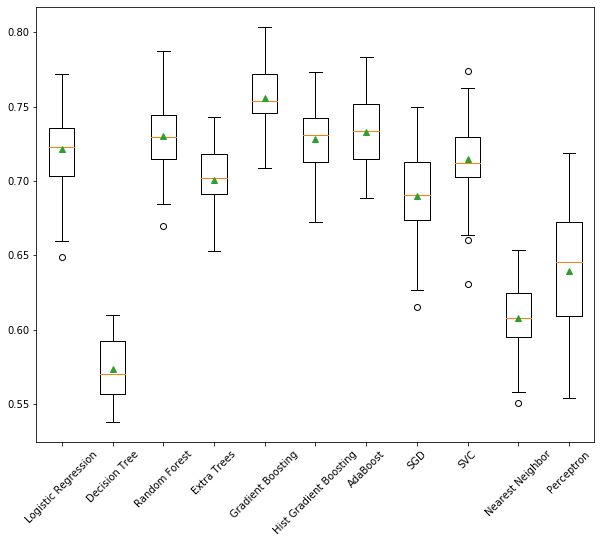

In [24]:
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    %time scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('* %s Score = %.3f StdDev = (%.3f)' % (name, np.mean(scores), np.std(scores)), '\n')

# plot model performance for comparison
plt.figure(figsize=(10,8))
plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation=45)

Here we get an excellent visual of each model’s performance. Certain algorithms performed poorly, and we can discard them for this use case, such as the simple **decision tree**, the **nearest neighbor classifier**, and the **perceptron classifier**. These are all some of the more simple models on the list, and it isn’t a surprise that they performed poorer than the others. **The Gradient Boosted Tree** was the best performing classifier with a ROC-AUC score of 0.756, true to its reputation. **AdaBoost** and **RandomForest** were the next best, with 0.733 and 0.730 scores, respectively.

We can also take a look at the time it took to run. Of these models, the **Gradient Boosted Tree** performed the slowest at 2.75 seconds, and **AdaBoost** the best of these at 886 milliseconds. Look at **Logistic Regression**; however, it performed reasonably well at 0.721 but was extremely fast at 290 milliseconds which might weigh into our selection process. **Logistic Regression** has the advantage of high explainability by utilizing its coefficients and is performing at about 10% of the time of the Gradient Boosted Tree.



The final selection is up to you, but these methods should give you a strong baseline for selecting the best model for your use case!

##### Conclusion

**Model Selection** is a critical step in your machine learning model building. Choosing the right model can greatly impact the performance of your machine learning model, and choosing the wrong model, can leave you with unacceptable results. We walked through the process of **preparing our data** by utilizing a Pipeline for consistency. We then built a list of models that we wanted to evaluate their performance. We used cross-validation to test each model on various data slices and finally plotted the results. Utilizing this process is a quick and powerful way to select the right model for your application!